In [104]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [105]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [106]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [107]:
hawaii_m = pd.read_csv("Resources/hawaii_measurements.csv")
hawaii_s = pd.read_csv("Resources/hawaii_stations.csv")

In [108]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [109]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [110]:
# View all of the classes that automap found
class_names = Base.classes.keys()
for class_name in class_names:
    print(class_name)

measurement
station


In [111]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [112]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [113]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

Text(0, 0.5, 'Precipitation (inches)')

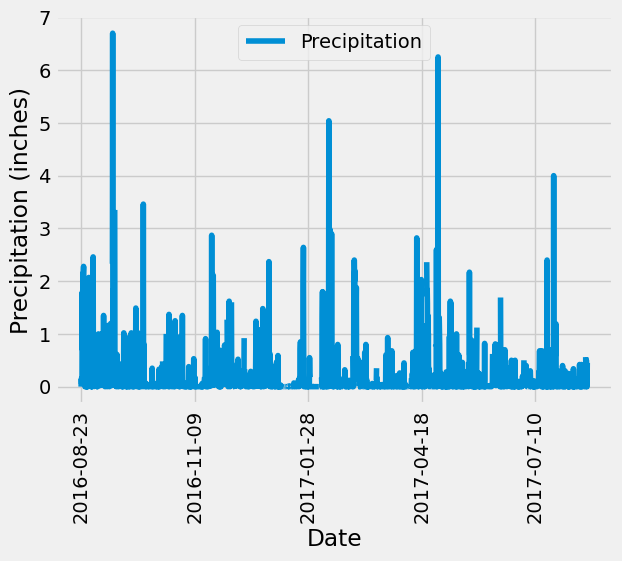

In [114]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date
# Calculate the date one year from the last date in the data set
one_year_ago = dt.date(2017,8,23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .order_by(measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')


In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [117]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(station.station))).scalar()

# Print the result
print("Total Number of Stations:", total_stations)


Total Number of Stations: 9


In [118]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(measurement.station, func.count(measurement.station).label('station_count'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = (
    session.query(
        func.min(measurement.tobs).label('min_temperature'),
        func.max(measurement.tobs).label('max_temperature'),
        func.avg(measurement.tobs).label('avg_temperature')
    )
    .filter(measurement.station == most_active_station_id)
    .all()
)
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

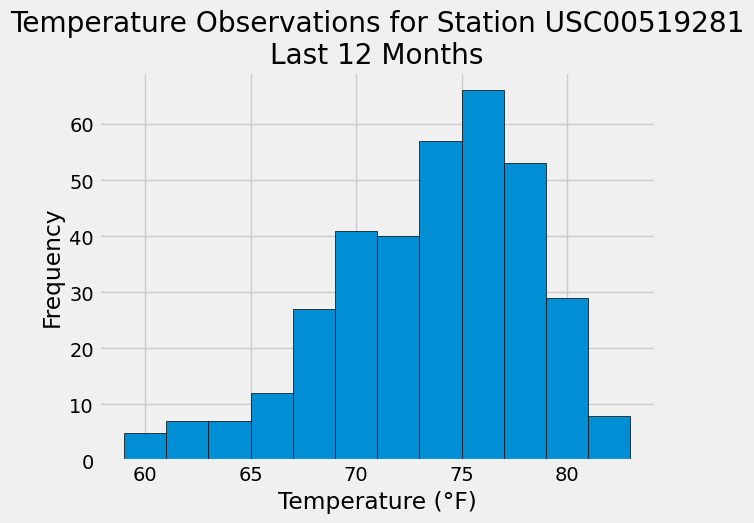

In [120]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Design a query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(measurement.date, measurement.tobs)
    .filter(and_(measurement.station == most_active_station_id, measurement.date >= one_year_ago))
    .all()
)

# Plot the results as a histogram
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [93]:
# Close Session
session.close()